In [1]:
import ROOT 
import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

ROOT.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/')
ROOT.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/external/')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootTreeReader.h"')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootConfReader.h"')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootTask.h"')
ROOT.gSystem.Load("/usr/local/Delphes-3.4.2/install/lib/libDelphes")

Welcome to JupyROOT 6.20/08


0

In [2]:
def get_info(path):
    # path: run path
    name = os.path.split(path)[1]

    with open(os.path.join(path, f'{name}_tag_1_banner.txt')) as f:
        for line in f.readlines():
                
            #  Integrated weight (pb)  :       0.020257
            match = re.match('#  Integrated weight \(pb\)  : +(\d+\.\d+)', line)
            if match:
                # unit: fb
                cross_section = float(match.group(1)) * 1000
            # #  Number of Events        :       100000
            match = re.match('#  Number of Events        :       (\d+)', line)
            if match:
                # unit: fb
                nevent = int(match.group(1))
    
    return cross_section, nevent

def Mjets(*arg):
    # arg: list of jets
    # return: invariant mass of jets
    e_tot, px_tot, py_tot, pz_tot = 0, 0, 0, 0
    
    for jet in arg:
        pt, eta, phi, m = jet[0], jet[1], jet[2], jet[3]
        
        px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
        e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
        
        px_tot += px
        py_tot += py
        pz_tot += pz
        e_tot += e
    
    return np.sqrt(e_tot**2 - px_tot**2 - py_tot**2 - pz_tot**2)

# Basic information

In [3]:
# Open root file
# root_file = './ppjj/Events/run_02/tag_1_delphes_events.root'
root_file = '../../Software/pythia8307/HVmodel/test.root'
f = ROOT.TFile(root_file)
# Print the tree structure
f.ls()

tree = f.Get("Delphes")

TFile**		../../Software/pythia8307/HVmodel/test.root	
 TFile*		../../Software/pythia8307/HVmodel/test.root	
  KEY: TProcessID	ProcessID0;1	d5489b38-8ff2-11ee-8a5d-0401a8c0beef
  KEY: TTree	Delphes;1	Analysis tree


In [4]:
# Get the branch names
for branch in tree.GetListOfBranches():
    print(branch.GetName())

Event
Event_size
Weight
Weight_size
Particle
Particle_size
Track
Track_size
Tower
Tower_size
EFlowTrack
EFlowTrack_size
EFlowPhoton
EFlowPhoton_size
EFlowNeutralHadron
EFlowNeutralHadron_size
GenJet
GenJet_size
GenMissingET
GenMissingET_size
Jet
Jet_size
Electron
Electron_size
Photon
Photon_size
Muon
Muon_size
FatJet
FatJet_size
MissingET
MissingET_size
ScalarHT
ScalarHT_size


In [5]:
# print Pythia data
for event_id, event in tqdm(enumerate(tree)):      

    if event_id == 163:
        print(event_id)
        print(f'{"pid":^5} {"PID":^8} {"M1":^8} {"M2":^8} {"D1":^8} {"D2":^8} {"Px":^8} {"Py":^8} {"Pz":^8}')
        printed = False
        for p_id, particle in enumerate(event.Particle):
            print(f'{p_id:5} {particle.PID:8} {particle.M1:8} {particle.M2:8} {particle.D1:8} {particle.D2:8} {particle.Px:8.2} {particle.Py:8.2} {particle.Pz:8.2} {particle.PT:8.2}')

        break


0it [00:00, ?it/s]

163it [00:00, 463.38it/s]

163
 pid    PID       M1       M2       D1       D2       Px       Py       Pz   
    0       -2        4       -1        3        3      0.0      0.0    2e+03      0.0
    1       21        4       -1       11       11   -1e+02  3.3e+01 -5.8e+01  1.1e+02
    2        2        6       -1        3        3      0.0      0.0 -3.8e+03      0.0
    3  4900023        0        2        7        7      0.0      0.0 -1.8e+03      0.0
    4       -2        8       -1        0        1  1.4e-14 -3.6e-15  2.1e+03  1.5e-14
    5        2        8       -1       23       23  1.5e+01  2.2e+01  7.7e+01  2.7e+01
    6        2        9       -1        2        2  7.1e-15      0.0 -3.8e+03  7.1e-15
    7  4900023        3       -1       10       10    1e+02 -3.3e+01 -1.7e+03  1.1e+02
    8       21       19       -1        4        5      0.0 -1.8e-15  2.2e+03  1.8e-15
    9        2       14       -1        6        6  1.8e-15      0.0 -3.8e+03  1.8e-15
   10  4900023        7       -1       21       

# Selection

In [3]:
def HV_selection(tree):
    # Hidden Valley model selection
    # 1. 2 jets
    # 2. pT > 750 GeV
    # 3. |eta| < 2.0

    n_event_count = 0
    n_jet_count = 0
    jet_pt_count = 0
    jet_eta_count = 0
    mjjs = []

    pt = [[],[]]

    for event_id, event in tqdm(enumerate(tree)):
        n_event_count += 1

        if event.Jet_size < 2:
            continue
        n_jet_count += 1

        pt[0].append(event.Jet[0].PT)
        pt[1].append(event.Jet[1].PT)
        if event.Jet[1].PT < 750:
            continue
        jet_pt_count += 1

        if abs(event.Jet[0].Eta) > 2.0 or abs(event.Jet[1].Eta) > 2.0:
            continue
        jet_eta_count += 1

        jets = [[event.Jet[i].PT, event.Jet[i].Eta, event.Jet[i].Phi, event.Jet[i].Mass] for i in range(2)]
        mjj = Mjets(*jets)
        mjjs.append(mjj)

        if mjj < 4300 or mjj > 5900:
            continue


    mjjs = np.array(mjjs)
    SR_count = ((mjjs > 4700) & (mjjs < 5500)).sum()
    SB_count = (((mjjs > 4300) & (mjjs < 4700)) | ((mjjs > 5500) & (mjjs < 5900))).sum()

    cutflow_number = {
        'Total': n_event_count,
        'n jet cut': n_jet_count,
        'jet pt cut': jet_pt_count,
        'jet eta cut': jet_eta_count,
        'Signal region': SR_count,
        'Sideband region': SB_count,
    }

    results = {
        'mjj': mjjs,
        'pt': np.array(pt),
        'cutflow_number': cutflow_number,
    }

    return results

In [4]:
root_file = '../../Software/pythia8307/HVmodel/test_100k.root'
f = ROOT.TFile(root_file)
tree_s = f.Get("Delphes")

results_s = HV_selection(tree_s)

100000it [02:40, 624.95it/s]


In [5]:
root_file = './ppjj/Events/run_02/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree_b = f.Get("Delphes")

results_b = HV_selection(tree_b)

100000it [02:18, 723.09it/s]
Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo for version 2 of class GenParticle read from the file ./ppjj/Events/run_02/tag_1_delphes_events.root
   has a different checksum than the previously loaded StreamerInfo.
   Reading objects of type GenParticle from the file ./ppjj/Events/run_02/tag_1_delphes_events.root 
   (and potentially other files) might not work correctly.
   Most likely the version number of the class was not properly
   updated [See ClassDef(GenParticle,2)].
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float T; //number
vs
   float CtgTheta; //number
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float X; //number
vs
   float D0; //number
Warning in <TStreamerInfo::Compare

In [9]:
print(results_s['cutflow_number'])
print(results_b['cutflow_number'])

{'Total': 100000, 'n jet cut': 99996, 'jet pt cut': 90901, 'jet eta cut': 89800, 'Signal region': 55844, 'Sideband region': 16079}
{'Total': 100000, 'n jet cut': 99963, 'jet pt cut': 57832, 'jet eta cut': 55523, 'Signal region': 1991, 'Sideband region': 3090}


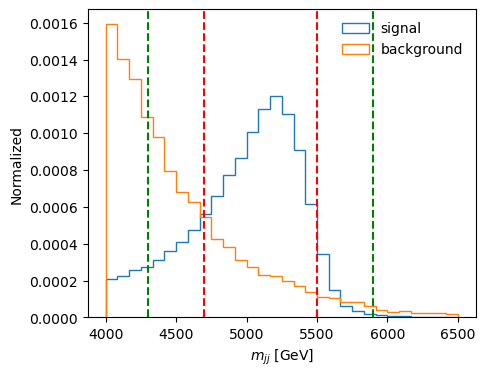

In [12]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))
ax.hist(results_s['mjj'], range=(4000, 6500), density=True, bins=30, histtype='step', label='signal')
ax.hist(results_b['mjj'], range=(4000, 6500), density=True, bins=30, histtype='step', label='background')

# 指定要繪製垂直線的x座標
SRSB_region = [[4700, 5500], [4300, 5900]]
x_SR = SRSB_region[0]
x_SB = SRSB_region[1]
# 使用axvline函數繪製垂直線
ax.axvline(x=x_SR[0], color='r', linestyle='--')
ax.axvline(x=x_SR[1], color='r', linestyle='--')

ax.axvline(x=x_SB[0], color='g', linestyle='--')
ax.axvline(x=x_SB[1], color='g', linestyle='--')

ax.set_xlabel('$m_{jj}$ [GeV]')
ax.set_ylabel('Normalized')
ax.legend(frameon=False)

plt.savefig('../figures/HVmodel_mjj_distribution.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

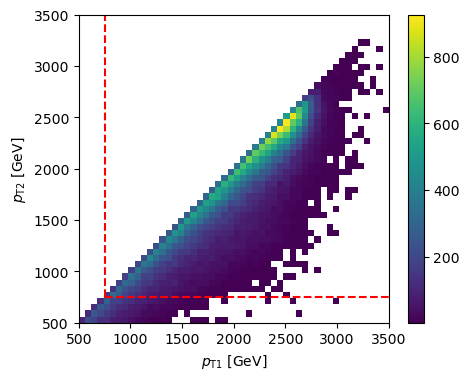

In [6]:
# plot leading and sub-leading pT distribution in 2d histogram
fig, ax = plt.subplots(1,1, figsize=(5, 4))
pt = results_s['pt']
hs = ax.hist2d(pt[0], pt[1], range=((500, 3500), (500, 3500)), bins=50, cmin=1)
# show color bar
fig.colorbar(hs[3], ax=ax)

ax.plot([750,750], [750,3500], color='r', linestyle='--')
ax.plot([750,3500], [750,750], color='r', linestyle='--')

ax.set_xlabel('$p_{\mathrm{T1}}$ [GeV]')
ax.set_ylabel('$p_{\mathrm{T2}}$ [GeV]')
plt.savefig('../figures/HVmodel_pt_distribution-sig.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

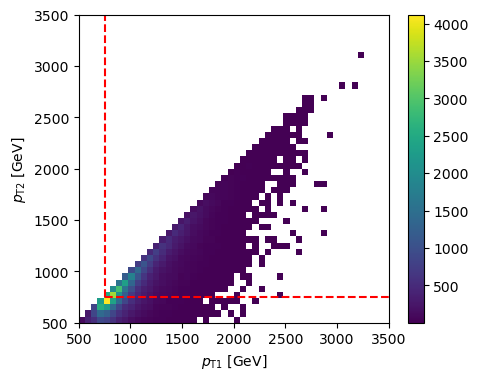

In [7]:
# plot leading and sub-leading pT distribution in 2d histogram
fig, ax = plt.subplots(1,1, figsize=(5, 4))
pt = results_b['pt']
hs = ax.hist2d(pt[0], pt[1], range=((500, 3500), (500, 3500)), bins=50, cmin=1)
# show color bar
fig.colorbar(hs[3], ax=ax)

ax.plot([750,750], [750,3500], color='r', linestyle='--')
ax.plot([750,3500], [750,750], color='r', linestyle='--')

ax.set_xlabel('$p_{\mathrm{T1}}$ [GeV]')
ax.set_ylabel('$p_{\mathrm{T2}}$ [GeV]')
plt.savefig('../figures/HVmodel_pt_distribution-bkg.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Generate jet image

In [6]:
def std_phi(phi):
    phi = np.where(phi > np.pi, phi - 2.*np.pi, phi)
    phi = np.where(phi < -np.pi, phi + 2.*np.pi, phi)
    return phi  

def preprocess(constituents):

    eta_flip, phi_flip = 1., 1.
    pts, etas, phis = [], [], []
    
    for consti in constituents:
        try:
            pts.append(consti.PT)
            etas.append(consti.Eta)
            phis.append(consti.Phi)
        except:
            pts.append(consti.ET)
            etas.append(consti.Eta)
            phis.append(consti.Phi)
            
    pts = np.array(pts)
    etas = np.array(etas)
    phis = np.array(phis)

    if np.var(phis) > 0.5:
        phis += np.pi
        phis = std_phi(phis)

    eta_central = (pts * etas).sum() / pts.sum()
    phi_central = (pts * phis).sum() / pts.sum()       

    s_etaeta = (pts * (etas - eta_central)**2).sum() / pts.sum()
    s_phiphi = (pts * (phis - phi_central)**2).sum() / pts.sum()
    s_etaphi = (pts * (etas - eta_central) * (phis - phi_central)).sum() / pts.sum()

    angle = -np.arctan((-s_etaeta + s_phiphi + np.sqrt((s_etaeta - s_phiphi)**2 + 4. * s_etaphi**2))/(2. * s_etaphi))
    
    eta_shift, phi_shift = etas - eta_central, std_phi(phis - phi_central)
    eta_rotat, phi_rotat = eta_shift * np.cos(angle) - phi_shift * np.sin(angle), phi_shift * np.cos(angle) + eta_shift * np.sin(angle)

    
    def quadrant_max(eta, phi, pt):
        if eta > 0. and phi > 0.:
            pt_quadrants[0] += pt
        elif eta > 0. and phi < 0.:
            pt_quadrants[1] += pt
        elif eta < 0. and phi < 0.:
            pt_quadrants[2] += pt
        elif eta < 0. and phi > 0.:
            pt_quadrants[3] += pt
    pt_quadrants = [0., 0., 0., 0.]
    np.vectorize(quadrant_max)(eta_rotat, phi_rotat, pts)

    if np.argmax(pt_quadrants) == 1:
        phi_flip = -1.
    elif np.argmax(pt_quadrants) == 2:
        phi_flip = -1.
        eta_flip = -1.
    elif np.argmax(pt_quadrants) == 3:
        eta_flip = -1.

    eta_news = eta_rotat * eta_flip
    phi_news = phi_rotat * phi_flip

    return pts, eta_news, phi_news

In [7]:
def HV_selection_jet_image(tree, output_path):
    # Hidden Valley model selection
    # 1. 2 jets
    # 2. pT > 750 GeV
    # 3. |eta| < 2.0

    n_event_count = 0
    n_jet_count = 0
    jet_pt_count = 0
    jet_eta_count = 0
    mjjs = []

    pt = [[],[]]

    with open(output_path, 'wb') as imageWriter:

        for event_id, event in tqdm(enumerate(tree)):
            n_event_count += 1

            if event.Jet_size < 2:
                continue
            n_jet_count += 1

            pt[0].append(event.Jet[0].PT)
            pt[1].append(event.Jet[1].PT)
            if event.Jet[1].PT < 750:
                continue
            jet_pt_count += 1

            if abs(event.Jet[0].Eta) > 2.0 or abs(event.Jet[1].Eta) > 2.0:
                continue
            jet_eta_count += 1

            jets = [[event.Jet[i].PT, event.Jet[i].Eta, event.Jet[i].Phi, event.Jet[i].Mass] for i in range(2)]
            mjj = Mjets(*jets)

            if mjj < 4300 or mjj > 5900:
                continue

            mjjs.append(mjj)
        
            # pre-process jet constituents
            constituents = [consti for consti in event.Jet[0].Constituents if consti != 0]
            pt_news, eta_news, phi_news = preprocess(constituents)
            hpT0, _, _ = np.histogram2d(eta_news, phi_news, range=((-1.0, 1.0), (-1.0, 1.0)), bins=(75, 75), weights=pt_news)

            constituents = [consti for consti in event.Jet[1].Constituents if consti != 0]
            pt_news, eta_news, phi_news = preprocess(constituents)
            hpT1, _, _ = np.histogram2d(eta_news, phi_news, range=((-1.0, 1.0), (-1.0, 1.0)), bins=(75, 75), weights=pt_news)

            image = np.array([mjj, np.array([hpT0, hpT1])], dtype=object)
            np.save(imageWriter, image)


    mjjs = np.array(mjjs)
    SR_count = ((mjjs > 4700) & (mjjs < 5500)).sum()
    SB_count = (((mjjs > 4300) & (mjjs < 4700)) | ((mjjs > 5500) & (mjjs < 5900))).sum()

    cutflow_number = {
        'Total': n_event_count,
        'n jet cut': n_jet_count,
        'jet pt cut': jet_pt_count,
        'jet eta cut': jet_eta_count,
        'Signal region': SR_count,
        'Sideband region': SB_count,
    }

    results = {
        'mjj': mjjs,
        'pt': np.array(pt),
        'cutflow_number': cutflow_number,
    }

    return results

In [ ]:
root_file = '../../Software/pythia8307/HVmodel/test_100k.root'
f = ROOT.TFile(root_file)
tree_s = f.Get("Delphes")

results_s = HV_selection_jet_image(tree_s,'./HVmodel/data/signal.npy')

100000it [04:43, 353.11it/s]


In [ ]:
root_file = './ppjj/Events/run_03/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree_b = f.Get("Delphes")

results_b = HV_selection_jet_image(tree_b,'./HVmodel/data/background.npy')

350089it [08:50, 603.23it/s]/tmp/ipykernel_1998759/783926957.py:36: RuntimeWarning: invalid value encountered in scalar divide
  angle = -np.arctan((-s_etaeta + s_phiphi + np.sqrt((s_etaeta - s_phiphi)**2 + 4. * s_etaphi**2))/(2. * s_etaphi))
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in quadrant_max (vectorized)
  outputs = ufunc(*inputs)
1000000it [24:33, 678.72it/s]
Error in <TObjArray::At>: index 33 out of bounds (size: 33, this: 0x55ab0e642410)
Error in <TObjArray::At>: index 34 out of bounds (size: 33, this: 0x55ab0e642410)
Error in <TObjArray::At>: index 35 out of bounds (size: 33, this: 0x55ab0e642410)
Error in <TObjArray::At>: index 36 out of bounds (size: 33, this: 0x55ab0e642410)
Error in <TObjArray::At>: index 37 out of bounds (size: 33, this: 0x55ab0e642410)
Error in <TObjArray::At>: index 38 out of bounds (size: 33, this: 0x55ab0e642410)
Error in <TObjArray::At>: index 39 out o

In [8]:
root_file = '../../Software/pythia8307/HVmodel/test_100k-2.root'
f = ROOT.TFile(root_file)
tree_s = f.Get("Delphes")

results_s = HV_selection_jet_image(tree_s,'./HVmodel/data/signal-test.npy')

100000it [05:22, 309.63it/s]


In [9]:
root_file = './ppjj/Events/run_04/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree_b = f.Get("Delphes")

results_b = HV_selection_jet_image(tree_b,'./HVmodel/data/background-test.npy')

1000000it [25:00, 666.34it/s]
Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo for version 2 of class GenParticle read from the file ./ppjj/Events/run_04/tag_1_delphes_events.root
   has a different checksum than the previously loaded StreamerInfo.
   Reading objects of type GenParticle from the file ./ppjj/Events/run_04/tag_1_delphes_events.root 
   (and potentially other files) might not work correctly.
   Most likely the version number of the class was not properly
   updated [See ClassDef(GenParticle,2)].
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float T; //number
vs
   float CtgTheta; //number
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float X; //number
vs
   float D0; //number
Warning in <TStreamerInfo::Compar

# Make training and testing data

## Compute samples sizes

In [6]:
# Total cross section and number of events
xection, tot_event = get_info('./ppjj/Events/run_03')
print(xection, tot_event)

6837.392481 1000000


In [7]:
# cross section in signal region and sideband region
cross_section_SR = results_b['cutflow_number']['Signal region'] / results_b['cutflow_number']['Total'] * xection
cross_section_SB = results_b['cutflow_number']['Sideband region'] / results_b['cutflow_number']['Total'] * xection
print(cross_section_SR, cross_section_SB)

136.13248429671 211.2754276629


In [8]:
# number of background events in signal region and sideband region
L = 139
n_SR_B = cross_section_SR * L
n_SB_B = cross_section_SB * L

print(n_SR_B, n_SB_B)

18922.415317242692 29367.2844451431


In [11]:
def create_mix_sample_from_numbers(sig_path, bkg_path, n_sig_1, n_sig_2, n_bkg_1, n_bkg_2, output_path):
    # n_sig_1: number of signal events in mixing sample 1 (Signal region)
    # n_sig_2: number of signal events in mixing sample 2 (Sideband region)

    data_SR_S, data_SB_S = [], []
    data_SR_B, data_SB_B = [], []
    with open(sig_path, 'rb') as f:
        n_SR = 0
        n_SB = 0
        data = np.load(f, allow_pickle=True)
        while n_SR < n_sig_1 or n_SB < n_sig_2:
            mjj = data[0]
            if mjj > 4700 and mjj < 5500:
                data_SR_S.append(data[1])
                n_SR += 1
            else:
                data_SB_S.append(data[1])
                n_SB += 1
            data = np.load(f, allow_pickle=True)

    with open(bkg_path, 'rb') as f:
        n_SR = 0
        n_SB = 0
        data = np.load(f, allow_pickle=True)
        while n_SR < n_bkg_1 or n_SB < n_bkg_2:
            mjj = data[0]
            if mjj > 4700 and mjj < 5500:
                data_SR_B.append(data[1])
                n_SR += 1
            else:
                data_SB_B.append(data[1])
                n_SB += 1
            data = np.load(f, allow_pickle=True)


    sig_data_1, sig_data_2 = data_SR_S[:n_sig_1], data_SB_S[:n_sig_2]
    bkg_data_1, bkg_data_2 = data_SR_B[:n_bkg_1], data_SB_B[:n_bkg_2]
    
    data = np.vstack([sig_data_1, bkg_data_1, sig_data_2, bkg_data_2])
    label = np.array([1] * (n_sig_1+ n_bkg_1) + [0] * (n_sig_2 + n_bkg_2))
    
    # shuffle
    ind_list = list(range(len(label)))
    random.shuffle(ind_list)

    data = data[ind_list]
    label = label[ind_list]

    root, ext = os.path.splitext(output_path)
    np.save(f'{root}-data.npy', data)
    np.save(f'{root}-label.npy', label)

In [42]:
sensitivity = 1
n_SR_S = sensitivity * np.sqrt(n_SR_B)
n_SB_S = n_SR_S * results_s['cutflow_number']['Sideband region'] / results_s['cutflow_number']['Signal region']
print(n_SR_S, n_SB_S)


1375.5877041193228 396.06895448991105


In [44]:
sig_path = './HVmodel/data/signal.npy'
bkg_path = './HVmodel/data/background.npy'
n_sig_1, n_sig_2, n_bkg_1, n_bkg_2 = int(n_SR_S), int(n_SB_S), int(n_SR_B), int(n_SB_B)
output_path = './HVmodel/data/mix_sample.npy'
create_mix_sample_from_numbers(sig_path, bkg_path, n_sig_1, n_sig_2, n_bkg_1, n_bkg_2, output_path)

In [12]:
sig_path = './HVmodel/data/signal.npy'
bkg_path = './HVmodel/data/background.npy'

for i in range(0,1):

    sensitivity = i
    n_SR_S = sensitivity * np.sqrt(n_SR_B)
    n_SB_S = n_SR_S * results_s['cutflow_number']['Sideband region'] / results_s['cutflow_number']['Signal region']

    n_sig_1, n_sig_2, n_bkg_1, n_bkg_2 = int(n_SR_S), int(n_SB_S), int(n_SR_B), int(n_SB_B)
    output_path = f'./HVmodel/data/mix_sample_{i:.1f}.npy'
    create_mix_sample_from_numbers(sig_path, bkg_path, n_sig_1, n_sig_2, n_bkg_1, n_bkg_2, output_path)

In [35]:
# Generate testing data
sig_path = './HVmodel/data/signal-test.npy'
bkg_path = './HVmodel/data/background-test.npy'

data_SR_S, data_SR_B = [], []
n = 10000

with open(sig_path, 'rb') as f:
    n_SR = 0
    data = np.load(f, allow_pickle=True)
    while n_SR < n:
        mjj = data[0]
        if mjj > 4700 and mjj < 5500:
            data_SR_S.append(data[1])
            n_SR += 1
        data = np.load(f, allow_pickle=True)


with open(bkg_path, 'rb') as f:
    n_SR = 0
    data = np.load(f, allow_pickle=True)
    while n_SR < n:
        mjj = data[0]
        if mjj > 4700 and mjj < 5500:
            data_SR_B.append(data[1])
            n_SR += 1
        data = np.load(f, allow_pickle=True)

data = np.vstack([data_SR_S, data_SR_B])
label = np.array([1] * n + [0] * n)
    
# shuffle
ind_list = list(range(len(label)))
random.shuffle(ind_list)

data = data[ind_list]
label = label[ind_list]

root, ext = os.path.splitext('./HVmodel/data/mix_sample_testing.npy')
np.save(f'{root}-data.npy', data)
np.save(f'{root}-label.npy', label)

# Training

In [1]:
for i in range(1,11):
    train_file = f'../Sample/HVmodel/data/mix_sample_{i:.1f}.npy'
    model_name = f'SB_{i:.1f}'
    sample_type = f'Sensitivity: {i:.1f}'
    cmd = f'python train_CNN.py {train_file} {model_name} "{sample_type}"'
    print(cmd)

python train_CNN.py ../Sample/HVmodel/data/mix_sample_1.0.npy SB_1.0 "Sensitivity: 1.0"
python train_CNN.py ../Sample/HVmodel/data/mix_sample_2.0.npy SB_2.0 "Sensitivity: 2.0"
python train_CNN.py ../Sample/HVmodel/data/mix_sample_3.0.npy SB_3.0 "Sensitivity: 3.0"
python train_CNN.py ../Sample/HVmodel/data/mix_sample_4.0.npy SB_4.0 "Sensitivity: 4.0"
python train_CNN.py ../Sample/HVmodel/data/mix_sample_5.0.npy SB_5.0 "Sensitivity: 5.0"
python train_CNN.py ../Sample/HVmodel/data/mix_sample_6.0.npy SB_6.0 "Sensitivity: 6.0"
python train_CNN.py ../Sample/HVmodel/data/mix_sample_7.0.npy SB_7.0 "Sensitivity: 7.0"
python train_CNN.py ../Sample/HVmodel/data/mix_sample_8.0.npy SB_8.0 "Sensitivity: 8.0"
python train_CNN.py ../Sample/HVmodel/data/mix_sample_9.0.npy SB_9.0 "Sensitivity: 9.0"
python train_CNN.py ../Sample/HVmodel/data/mix_sample_10.0.npy SB_10.0 "Sensitivity: 10.0"


In [3]:
for i in range(11):
    train_file = f'../Sample/HVmodel/data/DA/mix_sample_{i:.1f}_aug_1.npy'
    model_name = f'SB_{i:.1f}_aug_1'
    sample_type = f'Sensitivity: {i:.1f}, Augmentation: 1'
    cmd = f'python train_CNN.py {train_file} {model_name} "{sample_type}"'
    print(cmd)

python train_CNN.py ../Sample/HVmodel/data/DA/mix_sample_0.0_aug_1.npy SB_0.0_aug_1 "Sensitivity: 0.0, Augmentation: 1"
python train_CNN.py ../Sample/HVmodel/data/DA/mix_sample_1.0_aug_1.npy SB_1.0_aug_1 "Sensitivity: 1.0, Augmentation: 1"
python train_CNN.py ../Sample/HVmodel/data/DA/mix_sample_2.0_aug_1.npy SB_2.0_aug_1 "Sensitivity: 2.0, Augmentation: 1"
python train_CNN.py ../Sample/HVmodel/data/DA/mix_sample_3.0_aug_1.npy SB_3.0_aug_1 "Sensitivity: 3.0, Augmentation: 1"
python train_CNN.py ../Sample/HVmodel/data/DA/mix_sample_4.0_aug_1.npy SB_4.0_aug_1 "Sensitivity: 4.0, Augmentation: 1"
python train_CNN.py ../Sample/HVmodel/data/DA/mix_sample_5.0_aug_1.npy SB_5.0_aug_1 "Sensitivity: 5.0, Augmentation: 1"
python train_CNN.py ../Sample/HVmodel/data/DA/mix_sample_6.0_aug_1.npy SB_6.0_aug_1 "Sensitivity: 6.0, Augmentation: 1"
python train_CNN.py ../Sample/HVmodel/data/DA/mix_sample_7.0_aug_1.npy SB_7.0_aug_1 "Sensitivity: 7.0, Augmentation: 1"
python train_CNN.py ../Sample/HVmodel/da